# ImageNet-1k in 5GB

The full ImageNet-1k compressed to less than 5 GB

Compression procedure:

* Resize shorter edge to 288 and crop longer edge to a multiple of 32
* Analysis transform: [DC-AE f32 c32](https://huggingface.co/mit-han-lab/dc-ae-f32c32-sana-1.1-diffusers)
* Quantization: 8 bit float (e4m3)
* Entropy coding: TIFF (CMYK) with deflate

# Example dataloader for training

In [1]:
import torch
import datasets
from types import SimpleNamespace
from diffusers import AutoencoderDC
from torchvision.transforms.v2 import ToPILImage, PILToTensor, RandomCrop, CenterCrop
from walloc.walloc import pil_to_latent
from IPython.display import display 

In [2]:
device = 'cuda'
config = SimpleNamespace()
config.crop_size = 160
config.valid_crop_size = 288

ds = datasets.load_dataset('danjacobellis/imagenet_288_dcae_fp8')
decoder = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f32c32-sana-1.1-diffusers", torch_dtype=torch.float32).decoder.to(device)

rand_crop = RandomCrop((config.crop_size//32,config.crop_size//32))
cent_crop = CenterCrop((config.valid_crop_size//32,config.valid_crop_size//32))

def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, 32, config.crop_size//32, config.crop_size//32), dtype=torch.torch.float8_e4m3fn)
    y = torch.zeros(B, dtype=torch.long)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        z = pil_to_latent([sample['latent']], N=36, n_bits=8, C=4)[:,:32]
        x[i_sample,:,:,:] = rand_crop(z.to(torch.int8).view(torch.float8_e4m3fn))
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, 32, config.valid_crop_size//32, config.valid_crop_size//32), dtype=torch.torch.float8_e4m3fn)
    y = torch.zeros(B, dtype=torch.long)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        z = pil_to_latent([sample['latent']], N=36, n_bits=8, C=4)[:,:32]
        x[i_sample,:,:,:] = cent_crop(z.to(torch.int8).view(torch.float8_e4m3fn))
    return x, y

In [3]:
%%time
# warmup batch
x,y = valid_collate_fn(ds['train'].select(range(64)))
with torch.no_grad():
    xh = decoder(x.to(torch.float32).to(device))

CPU times: user 1.68 s, sys: 124 ms, total: 1.8 s
Wall time: 1.47 s


In [4]:
%%time
x,y = valid_collate_fn(ds['train'].select(range(64)))
with torch.no_grad():
    xh = decoder(x.to(torch.float32).to(device))

CPU times: user 282 ms, sys: 2.51 ms, total: 285 ms
Wall time: 29.2 ms


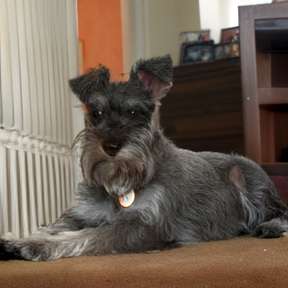

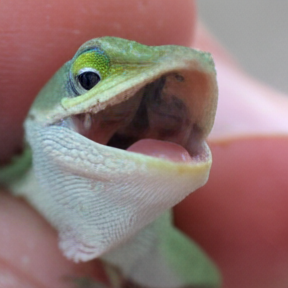

In [5]:
for img in xh[:2]:
    display(ToPILImage()(img.clamp(-0.5,0.5)+0.5))

In [7]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Writing 3077 bytes to README.md
